# Análisis de la metodología para la verificación y construcción de series históricas para el cálculo de la ENFICC en plantas solares fotovoltaicas

In [138]:
import os
import pandas as pd
from scipy import stats

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Funciones para importar los datos

In [139]:
def imp_id(ciudad):
    base_dir = os.path.join( '.','data')
    output_dir = os.path.join( '.','output')
    fuente = 'IDEAM'
    serie_csv = os.path.join(base_dir,ciudad,fuente+'.csv')
    serie_id = pd.read_csv(serie_csv, sep = ';',
                    encoding='latin-1')
    serie_id1 = serie_id[serie_id['AÑO'] >= 2006]
                         
    return serie_id1
                         
def imp_sat(ciudad):   
    base_dir = os.path.join( '.','data')
    output_dir = os.path.join( '.','output')
    fuente = 'NREL'
    serie_csv1 = os.path.join(base_dir,ciudad,fuente+'.csv')
    serie_sat = pd.read_csv(serie_csv1, sep = ';',
                    encoding='latin-1')
    serie_sat1 = serie_sat[serie_sat['AÑO'] >= 2006]
                            
    return serie_sat1

### Implementar una función para el cálculo de la ENFICC. La entrada a dicha función es una serie de 10 años en resolución horaria y la salida debe ser la ENFICC 99%, es decir la energía que se espera se puede superar el 99% del tiempo.

In [140]:
def Energia (serie):   
    def ghi_mensual(serie_horaria):
        agnos = sorted(serie_horaria['AÑO'].unique())
        ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "PromedioMes"])
        for agno in range(2006,2016):
            for mes in range(1,13):
                nombre_energia = list(serie_horaria)[-1]
                dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) &
                            (serie_horaria['MES'] == mes)]["DIA"].unique())
                ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno)
                                & (serie_horaria["MES"] == mes)),
                                            nombre_energia].sum()/1000
                ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1],
                            "PromedioMes":ghi_mes}
                ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
        return ghi_df

    def ghi_dia(serie_ghi_mensual):
            agnos = sorted(serie_ghi_mensual['AÑO'].unique())
            ghi_df = pd.DataFrame(columns=["AÑO", "MES", "PromedioDia"])
            for agno in agnos:
                for mes in range(1,13):
                    dias = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)
                                    & (serie_ghi_mensual["MES"] == mes))
                                             ,"DIAS"].item()
                    ghi_diario = serie_ghi_mensual.loc[(
                        (serie_ghi_mensual["AÑO"] == agno)
                                    & (serie_ghi_mensual["MES"] == mes)),
                        "PromedioMes"].item()/dias
                    ghi_dict = {"AÑO":agno, "MES":mes, "PromedioDia":ghi_diario}
                    ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
            return ghi_df
    
    ghi_mens_cal = ghi_mensual(serie)
    ghi_dia_cal = ghi_dia(ghi_mens_cal)
    data = sorted(ghi_dia_cal["PromedioDia"])
    num = range(len(data))
    percentil = 0.01
    enficc = ghi_dia_cal.quantile(q=percentil, numeric_only=True)["PromedioDia"]
    print('La ENFICC 99% es: ', enficc)

    return (enficc, data, num)

### Implementar una función que permita graficar la distribución de energía (Figura 38 del protocolo) y comparar entre diferentes series. La entrada corresponde a las diferentes series de 10 años en resolución horaria y la salida debe una gráfica similar a la mostrada en el documento.

In [141]:
def graf(data_ideam, data_nrel, data_ajust):

    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía Base IDEAM")
    pylab.plot(data_ideam[-1],data_ideam[1]/data_ideam[0],'-k', label='IDEAM')
    pylab.plot(data_nrel[-1],data_nrel[1]/data_ideam[0],'-r', label='NREL')
    pylab.plot(data_ajust[-1],data_ajust[1]/data_ideam[0],'-b', label='Ajustados')
    pylab.legend(loc='upper left')

### Implementar una función para la Metodología Medición-Correlación-Predicción (MCP) basada en la relación de varianzas planteada en la sección 3.1.4 del protocolo. La entrada a la función es la serie de corto plazo medida en sitio (OBJ) y la serie secundaría basada en información satelital correspondiente a 10 años de medición (REF). La salida debe corresponder a la serie de largo plazo (10 año, resolución horaria) ajustada siguiendo la metodología MCP.

In [142]:
def s(serie,anho,mes):
    s1 = serie[(serie['AÑO'] == anho) & (serie['MES'] <= mes)]
    return s1

In [143]:
def mcp(serie_real_short,serie_satel): 
    
    my= serie_real_short['IDEAM'].mean()
    mx= serie_satel['NREL'].mean()
    dy= serie_real_short['IDEAM'].std(ddof=0)
    dx= serie_satel['NREL'].std(ddof=0)
    
    fx_serie_ajustada = pd.DataFrame((my-((dy/dx)*mx))+((dy/dx)*serie_satel["NREL"])) 
    fx_serie_ajustada[fx_serie_ajustada<0]=0
    serie_ajus = serie_satel.copy()
    
    del serie_ajus['NREL']        
    serie_ajus['PromedioDia']=fx_serie_ajustada
    
    return (serie_ajus)

### Implemente funciones para el cálculo de los indicadores de error planteados en la sección 3.1.2 del protocolo, error RMS (RMSEn), error de sesgo medio (MBE) y Indice de Kolmogorov-Smagorinski (KSI%), la entrada a estas funciones son dos series de largo plazo (10 años y resolución horaria) y la salida el indicador de error dado.

In [214]:
def RMS(obs,aju):
    obsv=obs.values
    ajusv=aju.values
    maxi=np.max(obsv)
    mini=np.min(obsv)
    rms = ((sqrt((obsv-ajusv)**2).mean())/(maxi-mini))*100
    print("El error rms es: " + str(rms))
    return rms

In [253]:
def MBE(obs,aju):
    obsv=obs.values
    ajusv=aju.values
    mbe_val = abs(((sum(obsv-ajusv))/sum(obsv))*100)
    print("El error mbe es: " + str(mbe_val))
    return mbe_val

In [254]:
def KS(obs,aju):
    ks = stats.mstats.ks_2samp(obs,aju)
    print("El valor test y valor p por el método ksi es: ", (ks))
    return ks

### Analice la eficacia del método MCP - relación de varianzas para reducir los indicadores de error y el error en la ENFICC para series de tiempo de diferentes localizaciones en el territorio nacional. Analice el efecto de la longitud de la series de tiempo medida en sitio (OBJ) y el año utilizado. Comente sus hayazgos y complete su análisis con gráficas de buena calidad.

##### Para observar que tan bueno es el metodo de medición-correlación-predición, se efectuara este método para periodos de 1, 3, 6, 9 y 12 meses  para los años 2010, 2011, 2014 y 2015 con los datos obtenidos en el municipio de Uribia ubicado en la región de la Guajira

In [255]:
ideam = imp_id('Uribia')
sat = imp_sat('Uribia')
enficc_real = Energia(ideam)
enficc_sat = Energia(sat)

La ENFICC 99% es:  4.2818970848
La ENFICC 99% es:  4.62133983333


Mes de Enero del 2010

La ENFICC 99% es:  4.38053521684
El error rms es: 0.901632464781
El error mbe es: 0.31367023371
El valor test y valor p por el método ksi es:  (0.19999999999999998, 0.01645948492367658)


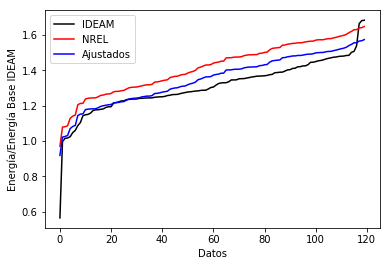

In [256]:
id_short10_1 = s(ideam,2010,1)
ajus10_1 = mcp(id_short10_1,sat)
enficc_ajus10_1= Energia(ajus10_1)
graf(enficc_real, enficc_sat, enficc_ajus10_1)
rms10_1 = RMS(ideam,ajus10_1)
mbe10_1= MBE(ideam,ajus10_1)
ks10_1= KS(enficc_real[1],enficc_ajus10_1[1])

Enero a Marzo del 2010

La ENFICC 99% es:  4.26495592002
El error rms es: 0.892166356358
El error mbe es: 0.0457547287316
El valor test y valor p por el método ksi es:  (0.10833333333333332, 0.48195404555853921)


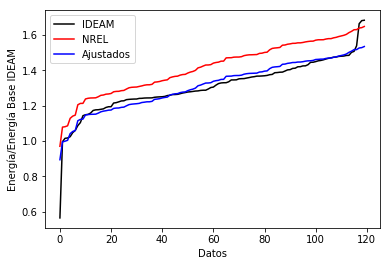

In [257]:
id_short10_3 = s(ideam,2010,3)
ajus10_3 = mcp(id_short10_3,sat)
enficc_ajus10_3 = Energia(ajus10_3)
graf(enficc_real, enficc_sat, enficc_ajus10_3)
rms10_3 = RMS(ideam,ajus10_3)
mbe10_3= MBE(ideam,ajus10_3)
ks10_3= KS(enficc_real[1],enficc_ajus10_3[1])

Enero a Junio del 2010

La ENFICC 99% es:  4.21435309509
El error rms es: 0.888621202579
El error mbe es: 0.0765175217552
El valor test y valor p por el método ksi es:  (0.14166666666666666, 0.17979920720867043)


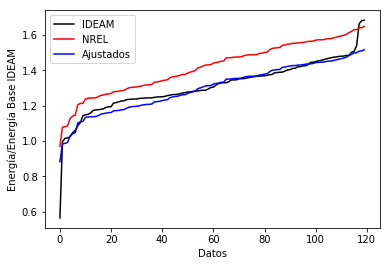

In [258]:
id_short10_6 = s(ideam,2010,6)
ajus10_6 = mcp(id_short10_6,sat)
enficc_ajus10_6 = Energia(ajus10_6)
graf(enficc_real, enficc_sat, enficc_ajus10_6)
rms10_6 = RMS(ideam,ajus10_6)
mbe10_6= MBE(ideam,ajus10_6)
ks10_6= KS(enficc_real[1],enficc_ajus10_6[1])

Enero a Septiembre del 2010

La ENFICC 99% es:  4.26695130924
El error rms es: 0.891277704503
El error mbe es: 0.0341623298355
El valor test y valor p por el método ksi es:  (0.10833333333333332, 0.48195404555853921)


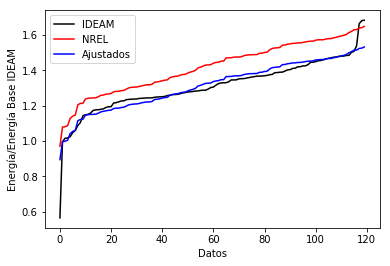

In [259]:
id_short10_9 = s(ideam,2010,9)
ajus10_9 = mcp(id_short10_9,sat)
enficc_ajus10_9 = Energia(ajus10_9)
graf(enficc_real, enficc_sat, enficc_ajus10_9)
rms10_9 = RMS(ideam,ajus10_9)
mbe10_9= MBE(ideam,ajus10_9)
ks10_9= KS(enficc_real[1],enficc_ajus10_9[1])

Todo el año 2010

La ENFICC 99% es:  3.99407104475
El error rms es: 0.880942729234
El error mbe es: 0.586922503042
El valor test y valor p por el método ksi es:  (0.26666666666666666, 0.00039359576488881754)


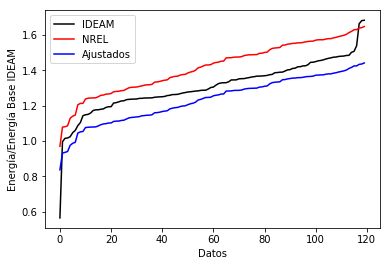

In [260]:
id_short10 = s(ideam,2010,12)
ajus10 = mcp(id_short10,sat)
enficc_ajus10 = Energia(ajus10)
graf(enficc_real, enficc_sat, enficc_ajus10)
rms10 = RMS(ideam,ajus10)
mbe10= MBE(ideam,ajus10)
ks10= KS(enficc_real[1],enficc_ajus10[1])

Mes de Enero del 2011

La ENFICC 99% es:  4.24297030629
El error rms es: 0.890027992979
El error mbe es: 0.0161862711752
El valor test y valor p por el método ksi es:  (0.12499999999999999, 0.30560385877265461)


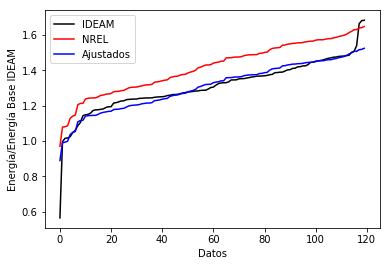

In [261]:
id_short11_1 = s(ideam,2011,1)
ajus11_1 = mcp(id_short11_1,sat)
enficc_ajus11_1= Energia(ajus11_1)
graf(enficc_real, enficc_sat, enficc_ajus11_1)
rms11_1 = RMS(ideam,ajus11_1)
mbe11_1= MBE(ideam,ajus11_1)
ks11_1= KS(enficc_real[1],enficc_ajus11_1[1])

Enero a Marzo 2011

La ENFICC 99% es:  4.29763981248
El error rms es: 0.89411859894
El error mbe es: 0.115347751491
El valor test y valor p por el método ksi es:  (0.14999999999999997, 0.13437022652861103)


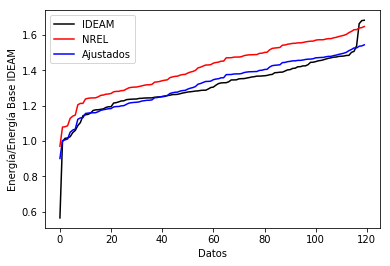

In [262]:
id_short11_3 = s(ideam,2011,3)
ajus11_3 = mcp(id_short11_3,sat)
enficc_ajus11_3= Energia(ajus11_3)
graf(enficc_real, enficc_sat, enficc_ajus11_3)
rms11_3 = RMS(ideam,ajus11_3)
mbe11_3= MBE(ideam,ajus11_3)
ks11_3= KS(enficc_real[1],enficc_ajus11_3[1])

Enero a Junio 2011

La ENFICC 99% es:  4.23386083842
El error rms es: 0.888943984823
El error mbe es: 0.046705477823
El valor test y valor p por el método ksi es:  (0.13333333333333333, 0.23649007143707598)


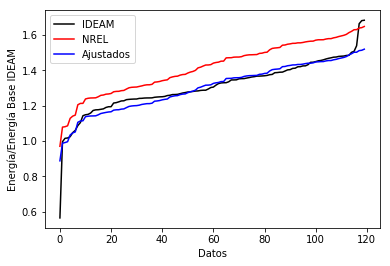

In [263]:
id_short11_6 = s(ideam,2011,6)
ajus11_6 = mcp(id_short11_6,sat)
enficc_ajus11_6= Energia(ajus11_6)
graf(enficc_real, enficc_sat, enficc_ajus11_6)
rms11_6 = RMS(ideam,ajus11_6)
mbe11_6= MBE(ideam,ajus11_6)
ks11_6= KS(enficc_real[1],enficc_ajus11_6[1])

Enero a Septiembre 2011

La ENFICC 99% es:  4.30655403011
El error rms es: 0.894103463771
El error mbe es: 0.126095244833
El valor test y valor p por el método ksi es:  (0.14999999999999997, 0.13437022652861103)


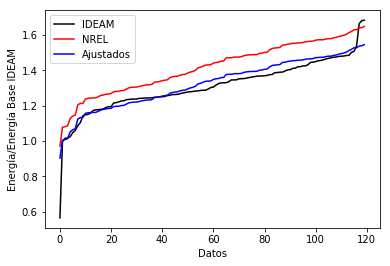

In [264]:
id_short11_9 = s(ideam,2011,9)
ajus11_9 = mcp(id_short11_9,sat)
enficc_ajus11_9= Energia(ajus11_9)
graf(enficc_real, enficc_sat, enficc_ajus11_9)
rms11_9 = RMS(ideam,ajus11_9)
mbe11_9= MBE(ideam,ajus11_9)
ks11_9= KS(enficc_real[1],enficc_ajus11_9[1])

Todo el año 2011

La ENFICC 99% es:  4.14447234839
El error rms es: 0.884917377311
El error mbe es: 0.241367569072
El valor test y valor p por el método ksi es:  (0.18333333333333332, 0.035430164672031722)


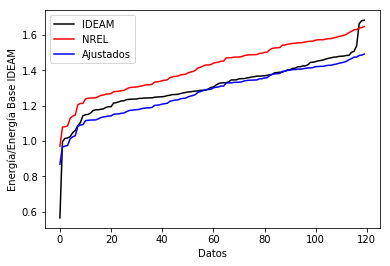

In [265]:
id_short11 = s(ideam,2011,12)
ajus11 = mcp(id_short11,sat)
enficc_ajus11 = Energia(ajus11)
graf(enficc_real, enficc_sat, enficc_ajus11)
rms11 = RMS(ideam,ajus11)
mbe11= MBE(ideam,ajus11)
ks11= KS(enficc_real[1],enficc_ajus11[1])

Mes de Enero del 2014

La ENFICC 99% es:  4.48235702802
El error rms es: 0.911387502421
El error mbe es: 0.538860877443
El valor test y valor p por el método ksi es:  (0.26666666666666666, 0.00039359576488881754)


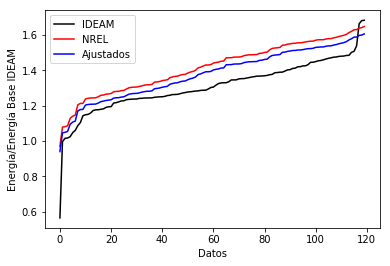

In [266]:
id_short14_1 = s(ideam,2014,1)
ajus14_1 = mcp(id_short14_1,sat)
enficc_ajus14_1= Energia(ajus14_1)
graf(enficc_real, enficc_sat, enficc_ajus14_1)
rms14_1 = RMS(ideam,ajus14_1)
mbe14_1= MBE(ideam,ajus14_1)
ks14_1= KS(enficc_real[1],enficc_ajus14_1[1])

Enero a Marzo del 2014

La ENFICC 99% es:  4.68196011653
El error rms es: 0.943675424515
El error mbe es: 1.0283317589
El valor test y valor p por el método ksi es:  (0.40833333333333377, 4.0880974233990664e-09)


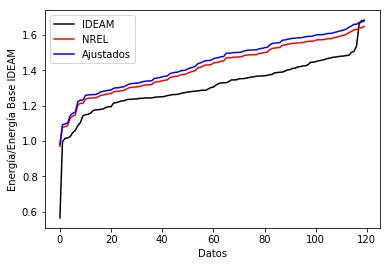

In [267]:
id_short14_3 = s(ideam,2014,3)
ajus14_3 = mcp(id_short14_3,sat)
enficc_ajus14_3= Energia(ajus14_3)
graf(enficc_real, enficc_sat, enficc_ajus14_3)
rms14_3 = RMS(ideam,ajus14_3)
mbe14_3= MBE(ideam,ajus14_3)
ks14_3= KS(enficc_real[1],enficc_ajus14_3[1])

Enero a Junio del 2014

La ENFICC 99% es:  4.29763981248
El error rms es: 0.89411859894
El error mbe es: 0.115347751491
El valor test y valor p por el método ksi es:  (0.14999999999999997, 0.13437022652861103)


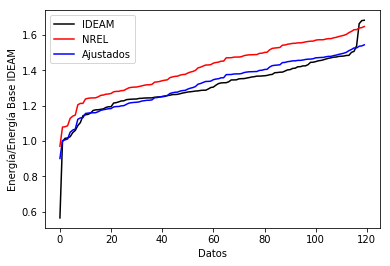

In [268]:
id_short11_3 = s(ideam,2011,3)
ajus11_3 = mcp(id_short11_3,sat)
enficc_ajus11_3= Energia(ajus11_3)
graf(enficc_real, enficc_sat, enficc_ajus11_3)
rms11_3 = RMS(ideam,ajus11_3)
mbe11_3= MBE(ideam,ajus11_3)
ks11_3= KS(enficc_real[1],enficc_ajus11_3[1])

Enero a Septiembre del 2014

La ENFICC 99% es:  4.56780280243
El error rms es: 0.925768879694
El error mbe es: 0.762066239941
El valor test y valor p por el método ksi es:  (0.32500000000000018, 6.2567303385464501e-06)


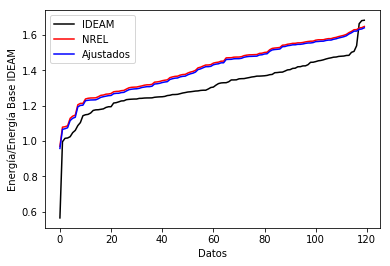

In [269]:
id_short14_9 = s(ideam,2014,9)
ajus14_9 = mcp(id_short14_9,sat)
enficc_ajus14_9= Energia(ajus14_9)
graf(enficc_real, enficc_sat, enficc_ajus14_9)
rms14_9 = RMS(ideam,ajus14_9)
mbe14_9= MBE(ideam,ajus14_9)
ks14_9= KS(enficc_real[1],enficc_ajus14_9[1])

Todo el año 2014

La ENFICC 99% es:  4.45788849487
El error rms es: 0.909786371373
El error mbe es: 0.493538938889
El valor test y valor p por el método ksi es:  (0.26666666666666666, 0.00039359576488881754)


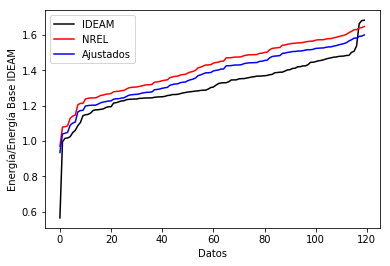

In [270]:
id_short14 = s(ideam,2014,12)
ajus14 = mcp(id_short14,sat)
enficc_ajus14 = Energia(ajus14)
graf(enficc_real, enficc_sat, enficc_ajus14)
rms14 = RMS(ideam,ajus14)
mbe14= MBE(ideam,ajus14)
ks14= KS(enficc_real[1],enficc_ajus14[1])

Mes de Enero del 2015

La ENFICC 99% es:  3.95129246695
El error rms es: 0.880914764773
El error mbe es: 0.718249334018
El valor test y valor p por el método ksi es:  (0.28333333333333338, 0.0001310166487984768)


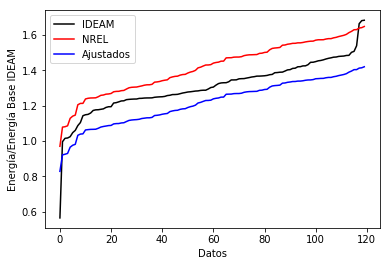

In [271]:
id_short15_1 = s(ideam,2015,1)
ajus15_1 = mcp(id_short15_1,sat)
enficc_ajus15_1= Energia(ajus15_1)
graf(enficc_real, enficc_sat, enficc_ajus15_1)
rms15_1 = RMS(ideam,ajus15_1)
mbe15_1= MBE(ideam,ajus15_1)
ks15_1= KS(enficc_real[1],enficc_ajus15_1[1])

Enero a Marzo del 2015

La ENFICC 99% es:  4.04402139197
El error rms es: 0.881289370715
El error mbe es: 0.499724746281
El valor test y valor p por el método ksi es:  (0.24166666666666664, 0.0018086290466114441)


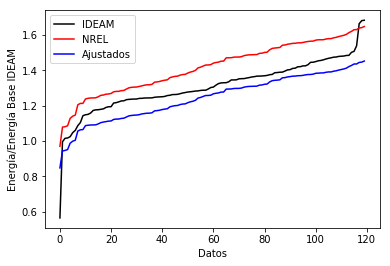

In [272]:
id_short15_3 = s(ideam,2015,3)
ajus15_3 = mcp(id_short15_3,sat)
enficc_ajus15_3= Energia(ajus15_3)
graf(enficc_real, enficc_sat, enficc_ajus15_3)
rms15_3 = RMS(ideam,ajus15_3)
mbe15_3= MBE(ideam,ajus15_3)
ks15_3= KS(enficc_real[1],enficc_ajus15_3[1])

Enero a Junio del 2015

La ENFICC 99% es:  4.3137689371
El error rms es: 0.894394998961
El error mbe es: 0.139141990265
El valor test y valor p por el método ksi es:  (0.15833333333333333, 0.098735914555483181)


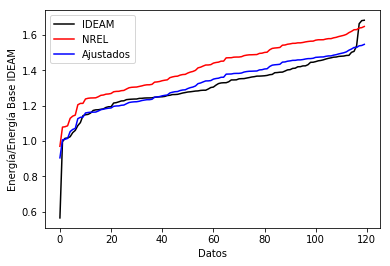

In [273]:
id_short15_6 = s(ideam,2015,6)
ajus15_6 = mcp(id_short15_6,sat)
enficc_ajus15_6= Energia(ajus15_6)
graf(enficc_real, enficc_sat, enficc_ajus15_6)
rms15_6 = RMS(ideam,ajus15_6)
mbe15_6= MBE(ideam,ajus15_6)
ks15_6= KS(enficc_real[1],enficc_ajus15_6[1])

Enero a Septiembre del 2015

La ENFICC 99% es:  4.45331633973
El error rms es: 0.90812123706
El error mbe es: 0.472031328648
El valor test y valor p por el método ksi es:  (0.24999999999999997, 0.0011061687401085157)


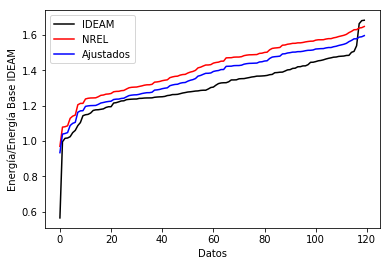

In [274]:
id_short15_9 = s(ideam,2015,9)
ajus15_9 = mcp(id_short15_9,sat)
enficc_ajus15_9= Energia(ajus15_9)
graf(enficc_real, enficc_sat, enficc_ajus15_9)
rms15_9 = RMS(ideam,ajus15_9)
mbe15_9= MBE(ideam,ajus15_9)
ks15_9= KS(enficc_real[1],enficc_ajus15_9[1])

Todo el año 2015

La ENFICC 99% es:  4.3664052986
El error rms es: 0.899298359425
El error mbe es: 0.268910383866
El valor test y valor p por el método ksi es:  (0.19166666666666665, 0.024350863752890358)


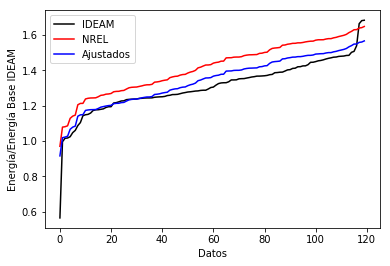

In [275]:
id_short15 = s(ideam,2015,12)
ajus15 = mcp(id_short15,sat)
enficc_ajus15 = Energia(ajus15)
graf(enficc_real, enficc_sat, enficc_ajus15)
rms15 = RMS(ideam,ajus15)
mbe15= MBE(ideam,ajus15)
ks15= KS(enficc_real[1],enficc_ajus15[1])

### Luego de obtener todos los ajustes propuestos se presentaran gráficos de comparación para poder relacionar los periodos de ajuste y el error que se obtuvo

In [276]:
data_err={'RMS 1 Mes %':[rms10_1,rms11_1,rms14_1,rms15_1],
               'MBE 1 Mes %':[mbe10_1,mbe11_1,mbe14_1,mbe15_1],
               'KSI 1 Mes':[ks10_1[-1],ks11_1[-1],ks14_1[-1],ks15_1[-1]],
               
               'RMS 3 Meses %':[rms10_3,rms11_3,rms14_3,rms15_3],
               'MBE 3 Meses %':[mbe10_3,mbe11_3,mbe14_3,mbe15_3],
               'KSI 3 Meses':[ks10_3[-1],ks11_3[-1],ks14_3[-1],ks15_3[-1]],
                              
               'RMS 6 Meses %':[rms10_6,rms11_6,rms14_6,rms15_6],
               'MBE 6 Meses %':[mbe10_6,mbe11_6,mbe14_6,mbe15_6],
               'KSI 6 Meses':[ks10_6[-1],ks11_6[-1],ks14_6[-1],ks15_6[-1]],
               
               'RMS 9 Meses %':[rms10_9,rms11_9,rms14_9,rms15_9],
               'MBE 9 Meses %':[mbe10_9,mbe11_9,mbe14_9,mbe15_9],
               'KSI 9 Meses':[ks10_9[-1],ks11_9[-1],ks14_9[-1],ks15_9[-1]],
               
               'RMS Año %':[rms10,rms11,rms14,rms15],
               'MBE Año %':[mbe10,mbe11,mbe14,mbe15],
               'KSI Año':[ks10[-1],ks11[-1],ks14[-1],ks15[-1]]}

err=pd.DataFrame(data_err,index=[2010,2011,2014,2015])
err

,KSI 1 Mes,KSI 3 Meses,KSI 6 Meses,KSI 9 Meses,KSI Año,MBE 1 Mes %,MBE 3 Meses %,MBE 6 Meses %,MBE 9 Meses %,MBE Año %,RMS 1 Mes %,RMS 3 Meses %,RMS 6 Meses %,RMS 9 Meses %,RMS Año %
2010,0.016459,4.819540e-01,1.797992e-01,0.481954,0.000394,0.313670,0.045755,0.076518,0.034162,0.586923,0.901632,0.892166,0.888621,0.891278,0.880943
2011,0.305604,1.343702e-01,2.364901e-01,0.134370,0.035430,0.016186,0.115348,0.046705,0.126095,0.241368,0.890028,0.894119,0.888944,0.894103,0.884917
2014,0.000394,4.088097e-09,4.088097e-09,0.000006,0.000394,0.538861,1.028332,-1.055966,0.762066,0.493539,0.911388,0.943675,0.944311,0.925769,0.909786
2015,0.000131,1.808629e-03,9.873591e-02,0.001106,0.024351,0.718249,0.499725,0.139142,0.472031,0.268910,0.880915,0.881289,0.894395,0.908121,0.899298


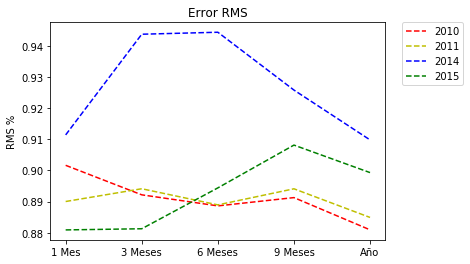

In [277]:
plt.title("Error RMS")
pylab.ylabel("RMS %")
pylab.plot(['1 Mes','3 Meses','6 Meses','9 Meses', 'Año'],err.loc[2010, ['RMS 1 Mes %','RMS 3 Meses %','RMS 6 Meses %','RMS 9 Meses %','RMS Año %']],'--r', label='2010')
pylab.plot(['1 Mes','3 Meses','6 Meses','9 Meses', 'Año'],err.loc[2011, ['RMS 1 Mes %','RMS 3 Meses %','RMS 6 Meses %','RMS 9 Meses %','RMS Año %']],'--y', label='2011')
pylab.plot(['1 Mes','3 Meses','6 Meses','9 Meses', 'Año'],err.loc[2014, ['RMS 1 Mes %','RMS 3 Meses %','RMS 6 Meses %','RMS 9 Meses %','RMS Año %']],'--b', label='2014')
pylab.plot(['1 Mes','3 Meses','6 Meses','9 Meses', 'Año'],err.loc[2015, ['RMS 1 Mes %','RMS 3 Meses %','RMS 6 Meses %','RMS 9 Meses %','RMS Año %']],'--g', label='2015')
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

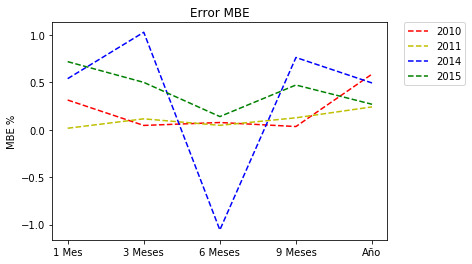

In [278]:
plt.title("Error MBE")
pylab.ylabel("MBE %")
pylab.plot(['1 Mes','3 Meses','6 Meses','9 Meses', 'Año'],err.loc[2010, ['MBE 1 Mes %','MBE 3 Meses %','MBE 6 Meses %','MBE 9 Meses %','MBE Año %']],'--r', label='2010')
pylab.plot(['1 Mes','3 Meses','6 Meses','9 Meses', 'Año'],err.loc[2011, ['MBE 1 Mes %','MBE 3 Meses %','MBE 6 Meses %','MBE 9 Meses %','MBE Año %']],'--y', label='2011')
pylab.plot(['1 Mes','3 Meses','6 Meses','9 Meses', 'Año'],err.loc[2014, ['MBE 1 Mes %','MBE 3 Meses %','MBE 6 Meses %','MBE 9 Meses %','MBE Año %']],'--b', label='2014')
pylab.plot(['1 Mes','3 Meses','6 Meses','9 Meses', 'Año'],err.loc[2015, ['MBE 1 Mes %','MBE 3 Meses %','MBE 6 Meses %','MBE 9 Meses %','MBE Año %']],'--g', label='2015')
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

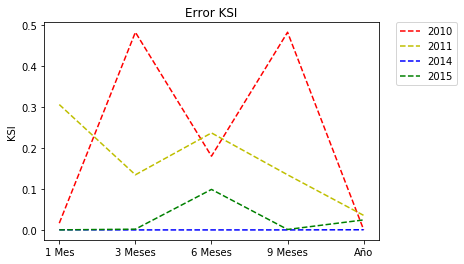

In [279]:
plt.title("Error KSI")
pylab.ylabel("KSI")
pylab.plot(['1 Mes','3 Meses','6 Meses','9 Meses', 'Año'],err.loc[2010, ['KSI 1 Mes','KSI 3 Meses','KSI 6 Meses','KSI 9 Meses','KSI Año']],'--r', label='2010')
pylab.plot(['1 Mes','3 Meses','6 Meses','9 Meses', 'Año'],err.loc[2011, ['KSI 1 Mes','KSI 3 Meses','KSI 6 Meses','KSI 9 Meses','KSI Año']],'--y', label='2011')
pylab.plot(['1 Mes','3 Meses','6 Meses','9 Meses', 'Año'],err.loc[2014, ['KSI 1 Mes','KSI 3 Meses','KSI 6 Meses','KSI 9 Meses','KSI Año']],'--b', label='2014')
pylab.plot(['1 Mes','3 Meses','6 Meses','9 Meses', 'Año'],err.loc[2015, ['KSI 1 Mes','KSI 3 Meses','KSI 6 Meses','KSI 9 Meses','KSI Año']],'--g', label='2015')
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Luego de observar los graficos que contienen los valores de las 3 funciones de error para cada uno de los 4 años escogidos, es posible observar que tanto en el RMS y el MBE se observa una tendencia a crecer para los años 2014 y 2015; lo cual se puede justificar por el hecho de que en este periodo de tiempo se presencio el fenómeno de El Niño de forma intensificada, por lo cual los valores que se presenciaron de radiación fueron mayores a los que se estaban pronosticando.
Adicionalmente, es posible observar en en el gráfico de error KSI que los años que presentan valores p mas cercanos a 1 son el 2010 y el 2011, años en los cuales se presento el fenómeno de La Niña por lo cual fueron años en que el pronóstico que se esperaba tenpia un comportamiento mas similar que los años en los que se presento el fenomeno de El Niño.
Finalmente, es posible observar que en todos los gráficos el periodo que genero un mejor pronostico para las series ajustadas fue el de 1 año, lo cual se puede ver explicado dado que es una cantidad de 